In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import mapclassify as mc
import matplotlib as mpl

In [2]:
def convert_abbrev_to_name(df, state_col):
    '''
        Converts the state abbreviations to their full name
        
        Takes a dataframe and the column name of the states
        
        Returns a dataframe with the updated information in a new column, called state_names
    '''
    states = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
              'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District Of Columbia', 
              'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 
              'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 
              'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 
              'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 
              'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 
              'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 
              'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 
              'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 
              'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}

    series = df[state_col].values

    series = np.array([states[key] for key in series])
    df['state_names'] = series

    return df

In [3]:
def get_gdf_one_district_multiple_sessions(district_id, statename, start_con, end_con):
    '''
        Creates a GeoDataFrame for one Congressional district, where each row represents a Congressional Session.
    '''
    
    if district_id == -1:
        directory = 'senate'
    else:
        directory = 'house'
        
        
    geo_df = pd.DataFrame()
    
    for i in range(start_con, end_con + 1):
        sf_fpath = '../congress-data/shapefiles/districtShapes%d/districts%d.shp' % (i, i)
        data_fpath = '../congress-data/%s/%s_%d.csv' % (directory, directory, i)
        
        map_df = gpd.read_file(sf_fpath)
        cong_df = pd.read_csv(data_fpath, index_col=0)
        
        cong_df['PCT'] = cong_df['missed_votes'] / cong_df['total_votes']
        cong_df = convert_abbrev_to_name(cong_df)

        merged = map_df.merge(cong_df, how='outer left', left_on=['STATENAME', 'DISTRICT'], right_on=['statenames', 'district'])
        #merged = merged[['geometry', 'party', 'PCT', 'STATENAME', 'DISTRICT']]
        
        
        ind = merged[(merged['STATENAME'] == statename) & (merged['DISTRICT'] == str(district_id))].index
        
        if len(ind) == 0:
            continue
        
        geo_df = geo_df.append(merged.loc[ind])
        geo_df.at[ind, 'Congress'] = int(i)
                
    return geo_df

In [4]:
def get_csv(chamber, congress):
    fpath = '../congress-data/%s/%s_%d.csv' % (chamber, chamber, congress)
    cong_df = pd.read_csv(fpath, index_col=0)
    
    cong_df['PCT'] = cong_df['missed_votes'] / cong_df['total_votes']
    cong_df = convert_abbrev_to_name(cong_df, 'state')
    
    if chamber == 'house':
        inds = cong_df['at_large'] == True
        cong_df.loc[inds, 'district'] = '0'
    
    return cong_df

def get_shapefile(chamber, congress):
    if chamber == 'house':
        fpath = '../congress-data/shapefiles/districtShapes%d/districts%d.shp' % (congress, congress)
        map_df = gpd.read_file(fpath)
    else:
        fpath = '../congress-data/shapefiles/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
        map_df = gpd.read_file(fpath)    
        map_df['STATENAME'] = map_df['NAME']
        
    return map_df

def get_merged_df(chamber, congress):
    map_df = get_shapefile(chamber, congress)
    cong_df = get_csv(chamber, congress)
    
    if chamber == 'house':
        left_on = ['STATENAME', 'DISTRICT']
        right_on = ['state_names', 'district']
    else:
        left_on = ['STATENAME']
        right_on = ['state_names']
    
    merged = map_df.merge(cong_df, how='inner', left_on=left_on, right_on=right_on)

    return merged

def get_oral_ind(num):
    
    if str(num)[-1] == '1' and num != 11:
        return 'st'
    elif str(num)[-1] == '2' and num != 12:
        return 'nd'
    elif str(num)[-1] == '3' and num != 13:
        return 'rd'
    else:
        return 'th'
    
def get_color(party, pct):
    if party == 'R':
        if pct <= 0.01:
            return '#FFEBEE'
        elif pct <= 0.03:
            return '#FFCDD2'
        elif pct <= 0.05:
            return '#EF9A9A'
        elif pct <= 0.07:
            return '#E57373'
        elif pct <= 0.09:
            return '#EF5350'
        elif pct <= 0.15:
            return '#F44336'
        else:
            return '#E53935'

    elif party == 'D':
        if pct <= 0.01:
            return '#E3F2FD'
        elif pct <= 0.03:
            return '#BBDEFB'
        elif pct <= 0.05:
            return '#90CAF9'
        elif pct <= 0.07:
            return '#64B5F6'
        elif pct <= 0.09:
            return '#42A5F5'
        elif pct <= 0.15:
            return '#2196F3'
        else:
            return '#1E88E5'

    elif party == 'O1':
        if pct <= 0.01:
            return '#F1F8E9'
        elif pct <= 0.03:
            return '#DCEDC8'
        elif pct <= 0.05:
            return '#C5E1A5'
        elif pct <= 0.07:
            return '#AED581'
        elif pct <= 0.09:
            return '#9CCC65'
        elif pct <= 0.15:
            return '#8BC34A'
        else:
            return '#7CB342'

    elif party == 'O2':
        if pct <= 0.01:
            return '#FFFDE7'
        elif pct <= 0.03:
            return '#FFF9C4'
        elif pct <= 0.05:
            return '#FFF59D'
        elif pct <= 0.07:
            return '#FFF176'
        elif pct <= 0.09:
            return '#FFEE58'
        elif pct <= 0.15:
            return '#FFEB3B'
        else:
            return '#FDD835'
        
def add_colorbar(ax, party):
    
    if party == 'R':
        cmap = ListedColormap(['#FFEBEE', '#FFCDD2', '#EF9A9A', '#E57373', '#EF5350', '#F44336', '#E53935'])
    elif party == 'D':
        cmap = ListedColormap(['#E3F2FD', '#BBDEFB', '#90CAF9', '#64B5F6', '#42A5F5', '#2196F3', '#1E88E5'])
    else:
        cmap = ListedColormap(['#F1F8E9', '#DCEDC8', '#C5E1A5', '#AED581', '#9CCC65', '#8BC34A', '#7CB342'])
        
    bounds = [.125, .25, .375, .5, .625, .75, .875, 1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    boundaries= bounds,
                                    spacing='proportional',
                                    orientation='vertical')
    cb2.set_ticks([.1875, .3125, .4375, .5625, .6875, .8125, .9375])
    cb2.set_ticklabels(['<1%', '1-3%', '3-5%', '5-7%', '7-9%', '9-15%', '>15%'])
    cb2.set_label('Percentage of missed votes')

In [5]:
def plot_by_state(statename, congress, xlim=None, ylim=None):
    '''
        Plots an entire state, when given a Congressional session
    '''
    merged = get_merged_df('house', congress)
    state = merged[merged['STATENAME'] == statename]
        
    rs = state[state['party'] == 'R']
    ds = state[state['party'] == 'D']
    
    fig, ax = plt.subplots(figsize=(10, 6))
   
    # set the value column that will be visualised
    variable = 'PCT'
    
    if len(rs) > 0:
        ax1 = rs.plot(column=variable, ax=ax, legend=True, cmap='Reds', scheme='UserDefined', 
                      classification_kwds={'bins': [0.01, 0.02, 0.03, 0.05, 0.09, 0.15, 0.3, 1]},
                      #missing_kwds={
                      #                                   "color": "lightgrey",
                      #                                   "edgecolor": "black",
                      #                                   "hatch": "////",
                      #                                   "label": "No data"
                      #                               },
                      edgecolor='black')
    if len(ds) > 0:
        ax2 = ds.plot(column=variable, ax=ax, legend=True, cmap='Blues', scheme='UserDefined',
                      classification_kwds={'bins': [0.01, 0.02, 0.03, 0.05, 0.09, 0.15, 0.3, 1]},
                     edgecolor='black')
        
    if xlim != None:
        ax.set_xlim(xlim)
        
    if ylim != None:
        ax.set_ylim(ylim)
        
    ind = get_oral_ind(congress)
    title = '%s\'s Districts - %d%s Congress' % (statename, congress, ind)
    ax.set_title(title)

In [ ]:
### NEED TO WORK ON

def plot_district(ax, merged, merged_id):
    fig, ax = plt.subplots(figsize=(10, 6))

    #merged = map_df.merge(congress_data, how='inner', left_on=['STATENAME', 'DISTRICT'], right_on=['statenames', 'district'])
    #merged = merged[['geometry', 'party', 'PCT', 'STATENAME', 'DISTRICT']]    
    #state = merged[merged['STATENAME'] == statename]

    #rs = state[state['party'] == 'R']
    #ds = state[state['party'] == 'D']
    # set the value column that will be visualised
    if merged.loc[merged_id]['party'] == 'R':
        cmap='Reds'
    else:
        cmap='Blues'
    
    variable = 'PCT'
    # create map
    ax1 = merged.loc[[merged_id]].plot(column=variable, ax=ax, legend=True, cmap=cmap, scheme='UserDefined', 
                  classification_kwds={'bins': [0.01, 0.02, 0.03, 0.05, 0.09, 0.15, 0.3, 1]},)
    #ax2 = ds.plot(column=variable, ax=ax, legend=True, cmap='Blues', scheme='UserDefined',
    #              classification_kwds={'bins': [0.01, 0.02, 0.03, 0.05, 0.09, 0.15, 0.3, 1]},)

In [ ]:
### NEED TO WORK ON

def district_change_over_time(district_id, statename, start_con, end_con):
    geo_df = get_gdf_one_district_multiple_sessions(district_id, statename, start_con, end_con)
        
    num_sessions = len(geo_df)
    
    cols = 2
    rows = num_sessions // cols + 1
    fig, ax = plt.subplots(num_sessions, 1, figsize=(16, 20))
    
    index = geo_df.index
    
    if str(district_id)[-1] == '1':
        oral_ind = 'st'
    elif str(district_id)[-1] == '2':
        oral_ind = 'nd'
    elif str(district_id)[-1] == '3':
        oral_ind = 'rd'
    else:
        oral_ind = 'th'
    
    
    
    for i, idx in enumerate(index):
        ax_ = ax[i]
        
        
        print(geo_df.loc[idx])
        if geo_df.loc[idx]['party'] == 'R':
            cmap='Reds'
        else:
            cmap='Blues'

        variable = 'PCT'
        
        cong = str(geo_df.loc[idx]['Congress'])
        
        if cong[-1] == '1' and cong != '11':
            cong_ind = 'st'
        elif cong[-1] == '2' and cong != '12':
            cong_ind = 'nd'
        elif cong[-1] == '3' and cong != '13':
            cong_ind = 'rd'
        else:
            cong_ind = 'th'
       
        
        
        title = '%s\'s %d%s Congressional District - %s%s Congress' % (statename, district_id, oral_ind, cong, cong_ind)
        
        
        merged.loc[[idx]].plot(column=variable, ax=ax_, cmap=cmap, legend=True, edgecolor='black',)
        ax_.set_title(title)
        
    plt.tight_layout()




In [6]:
def plot_district(statename, congress, district):

    merged = get_merged_df('house', congress)
        
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [6, 1]})
    
    df = merged[(merged['STATENAME'] == statename) & (merged['DISTRICT'] == str(district))]

    party = df['party'].values[0]
    pct = df['PCT'].values[0]

    if party == 'R':
        cmap='Reds'
    else:
        cmap='Blues'

    facecolor = get_color(party, pct)

    ax1 = df.plot(ax=ax[0], facecolor=facecolor,
              edgecolor='black')

    centroid = df.centroid

    cong_ind = get_oral_ind(congress)
    dist_ind = get_oral_ind(district)
    title = '%s\'s %d%s District - %d%s Congress' % (statename, district, dist_ind, congress, cong_ind)
    ax[0].set_title(title)
    ax[0].text(centroid.x, centroid.y, '%d%%' % (pct * 100))


    add_colorbar(ax[1], party)


/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



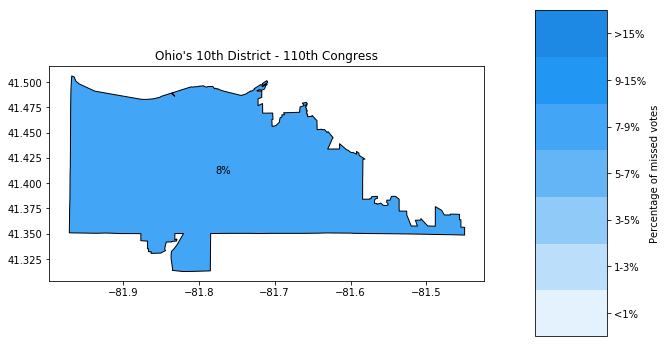

In [134]:
plot_district('Ohio', 110, district=10)

In [131]:
def get_hline(center_y, df):
    xs = []
    
    arr = df.loc[[0]]['geometry'][0]
    
    for polygon in arr:
        string = str(polygon)
        string = string.lstrip('POLYGON ((').rstrip('))').split(', ')
        for coord in string:
            coord = coord.split(' ')
            lat = float(coord[0])
            long = float(coord[1])

            if (long <= center_y + 0.01) and (long >= center_y - 0.01):
                xs.append(lat)
                
    return min(xs), max(xs)


def plot_state(statename, congress):

    merged = get_merged_df('senate', congress)
    df = merged[(merged['STATENAME'] == statename)]
    df = df.reset_index()
    
    num_entries = len(df)
    
    fname1 = df.loc[0]['first_name']
    lname1 = df.loc[0]['last_name']
    pct1 = df.loc[0]['PCT']
    party1 = df.loc[0]['party']
    
    bounds = df.loc[[0]].bounds
    center_y = df.loc[[0]].centroid.y.values[0]
    
    xmin, xmax = get_hline(center_y, df)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    df.loc[[0]].plot(ax=ax, color='white', edgecolor='black')
    ax.hlines(y=center_y, xmin=xmin, xmax=xmax)
        
        
        
        
    return df
        
    #fig, ax = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [6, 1]})
    

    #party = df['party'].values[0]
    #pct = df['PCT'].values[0]

    #if party == 'R':
    #    cmap='Reds'
    #else:
    #    cmap='Blues'

    #facecolor = get_color(party, pct)

    #ax1 = df.plot(ax=ax[0], facecolor=facecolor,
    #          edgecolor='black')

    #centroid = df.centroid

    #cong_ind = get_oral_ind(congress)
    #dist_ind = get_oral_ind(district)
    #title = '%s\'s %d%s District - %d%s Congress' % (statename, district, dist_ind, congress, cong_ind)
    #ax[0].set_title(title)
    #ax[0].text(centroid.x, centroid.y, '%d%%' % (pct * 100))


    #add_colorbar(ax[1], party)

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



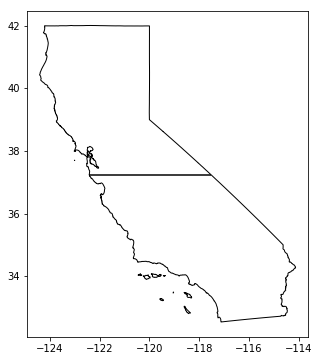

In [132]:
df = plot_state('California', 110)

In [84]:
center_y = df.loc[[0]].centroid.y.values[0]
center_y

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


37.24607274643382

In [130]:
arr = df.loc[[0]]['geometry'][0]
for polygon in arr:
    string = str(polygon)
    string = string.lstrip('POLYGON ((').rstrip('))').split(', ')
    for coord in string:
        coord = coord.split(' ')
        lat = float(coord[0])
        long = float(coord[1])
        
        if (long <= center_y + 0.01) and (long >= center_y - 0.01):
            print(lat, long)
    


-117.540885 37.249931
-122.419113 37.24147
-122.418452 37.248521


In [120]:
string = str(arr[0][0])
string.lstrip('POLYGON ((').rstrip('))').split(', ')

['-118.604415 33.478552',
 '-118.598783 33.477939',
 '-118.585936 33.473819',
 '-118.580255 33.475099',
 '-118.570351 33.47531',
 '-118.557605 33.474722',
 '-118.54453 33.474119',
 '-118.538624 33.477015',
 '-118.534276 33.473493',
 '-118.530702 33.468071',
 '-118.528239 33.466603',
 '-118.524769 33.466355',
 '-118.522635 33.462016',
 '-118.510537 33.455313',
 '-118.50285 33.453302',
 '-118.500212 33.449592',
 '-118.499574 33.445931',
 '-118.500288 33.443352',
 '-118.497435 33.441964',
 '-118.493632 33.442559',
 '-118.489354 33.445336',
 '-118.486264 33.446724',
 '-118.482224 33.44831',
 '-118.477646 33.448392',
 '-118.473485 33.442877',
 '-118.47034 33.442956',
 '-118.454636 33.433961',
 '-118.449535 33.432673',
 '-118.445812 33.428907',
 '-118.442276 33.428645',
 '-118.436905 33.428637',
 '-118.434805 33.426781',
 '-118.430172 33.428278',
 '-118.423576 33.427258',
 '-118.409099 33.421203',
 '-118.406444 33.421559',
 '-118.39525 33.416204',
 '-118.390955 33.417963',
 '-118.382037 33.4

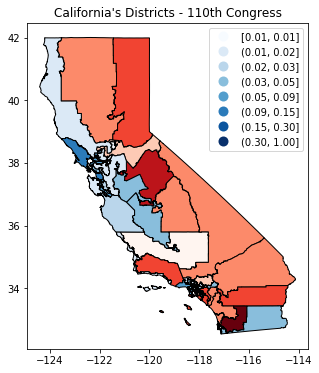

In [135]:
plot_by_state('California', 110)

In [101]:
fp = '../congress-data/shapefiles/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
map_df = gpd.read_file(fp)
# check the GeoDataframe
map_df

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ..."
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ..."
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ..."
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3..."
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


In [108]:
house_110 = pd.read_csv('../congress-data/senate/senate_110.csv', index_col=0)
house_110['PCT'] = house_110['missed_votes'] / house_110['total_votes']
house_110 = convert_abbrev_to_name(house_110, 'state')

In [109]:
house_110.head()

,id,first_name,last_name,dob,gender,party,leadership_role,govtrack_id,cspan_id,seniority,total_votes,missed_votes,total_present,state,senate_class,PCT,state_names
0,A000069,Daniel,Akaka,1924-09-11,M,D,False,300001,8704.0,17,657,2,0,HI,1,0.003044,Hawaii
1,A000360,Lamar,Alexander,1940-07-03,M,R,False,300002,5.0,5,657,29,0,TN,2,0.044140,Tennessee
2,A000109,Wayne,Allard,1943-12-02,M,R,False,300003,NaN,11,657,23,0,CO,2,0.035008,Colorado
4,B000243,Max,Baucus,1941-12-11,M,D,False,300005,1727.0,29,657,2,0,MT,2,0.003044,Montana
5,B001233,Evan,Bayh,1955-12-26,M,D,False,300006,NaN,9,657,19,0,IN,3,0.028919,Indiana


In [198]:
house_110.loc[387]

id                    S000465
first_name                Ike
last_name             Skelton
dob                1931-12-20
gender                      M
party                       D
leadership_role         False
govtrack_id            400377
cspan_id                  449
seniority                  32
total_votes              1873
missed_votes               43
total_present               1
state                      MO
district                    4
at_large                False
geoid                    2904
PCT                 0.0229578
statenames           Missouri
Name: 387, dtype: object

In [11]:
# join the geodataframe with the csv dataframe
merged = map_df.merge(house_110, how='inner', left_on=['STATENAME', 'DISTRICT'], right_on=['statenames', 'district'])
merged = merged[['geometry', 'party', 'PCT', 'STATENAME', \
                'DISTRICT']]
merged.head()

,geometry,party,PCT,STATENAME,DISTRICT
0,"POLYGON ((-80.30847 25.77738, -80.30967 25.771...",R,0.036305,Florida,21
1,"POLYGON ((-94.43377 35.31490, -94.43367 35.317...",R,0.010678,Arkansas,3
2,"POLYGON ((-80.18457 25.84757, -80.18457 25.846...",D,0.047517,Florida,17
3,"MULTIPOLYGON (((-80.31227 25.63808, -80.31217 ...",R,0.033636,Florida,18
4,"MULTIPOLYGON (((-80.21477 26.04647, -80.21497 ...",D,0.031500,Florida,20


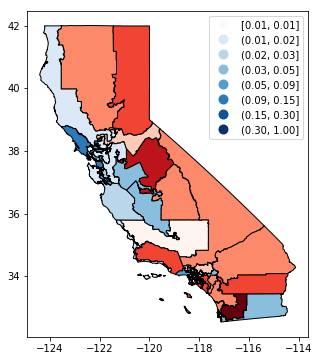

In [72]:
plot_by_state('California', map_df, house_110)

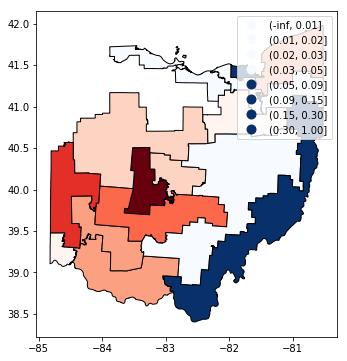

In [73]:
plot_by_state('Ohio', map_df, house_110)

In [30]:
district_change_over_time(20, 'California', 105, 108)

../congress-data/house/house_105.csv
../congress-data/house/house_106.csv
../congress-data/house/house_107.csv
../congress-data/house/house_108.csv
